In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch
import warnings
warnings.filterwarnings('ignore')

from fddbenchmark import FDDDataset, FDDDataloader, FDDEvaluator

from fdd_defense.models import MLP, TCN, GRU
from fdd_defense.attackers import *
from fdd_defense.defenders import *
from fdd_defense.utils import accuracy

### Dataset preparation
https://github.com/airi-industrial-ai/fddbenchmark.git - fdd benchmark with TEP dataset

In [2]:
dataset = FDDDataset(name='small_tep')
scaler = StandardScaler()
scaler.fit(dataset.df[dataset.train_mask])
dataset.df[:] = scaler.transform(dataset.df)

Reading data/small_tep/dataset.csv:   0%|          | 0/153300 [00:00<?, ?it/s]

Reading data/small_tep/labels.csv:   0%|          | 0/153300 [00:00<?, ?it/s]

Reading data/small_tep/train_mask.csv:   0%|          | 0/153300 [00:00<?, ?it/s]

Reading data/small_tep/test_mask.csv:   0%|          | 0/153300 [00:00<?, ?it/s]

### Model creation and training
window_size -- the size of sliding window  
model -- can be selected from MLP, TCN and GRU

In [ ]:
window_size = 32
model = TCN(
        window_size=window_size,
        step_size=1,
        device='cpu',
        kernel_size=5,
        num_layers=4,
        dilation_base=1,
        num_epochs=1,
        batch_size=512,
        lr=0.001,
        )
model.fit(dataset)

#model = MLP(
#        window_size=window_size,
#        step_size=1,
#        device='cuda',
#        hidden_dim=2048,
#        num_epochs=20,
#        batch_size=512,
#        lr=0.001,
#        )
#model = GRU(
#        window_size=window_size,
#        step_size=1,
#        device='cuda',
#        hidden_dim=128,
#        num_epochs=5,
#        batch_size=512,
#        lr=0.001,
#        )

Creating sequence of samples: 100%|█████████| 105/105 [00:00<00:00, 4687.62it/s]


Epochs ...:   0%|          | 0/1 [00:00<?, ?it/s]

Steps ...:   0%|          | 0/97 [00:00<?, ?it/s]

### Accuracy of the model

In [ ]:
attacker = NoAttacker(model, eps=0.05) # no attack
defender = NoDefenceDefender(model) # no defense
acc = accuracy(attacker, defender, step_size=1)
print(f'Accuracy: {acc:.4f}')

### Accuracy of the model under attack
epsilon -- limits the maximum shift in attacked data  
attacker -- can be selected from FGSMAttacker, NoiseAttacker, PGDAttacker, CarliniWagnerAttacker, DeepFoolAttacker and DistillationBlackBoxAttacker

In [5]:
eps_space = np.linspace(1e-6, 0.3, 20)
unprotected_acc = []
defender = NoDefenceDefender(model)
for eps in eps_space:
    attacker = CarliniWagnerAttacker(model, eps=eps)
    unprotected_acc.append(accuracy(attacker, defender, step_size=10))

Creating sequence of samples: 100%|█████████| 105/105 [00:00<00:00, 5346.05it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

Creating sequence of samples: 100%|█████████| 105/105 [00:00<00:00, 5500.01it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

Creating sequence of samples: 100%|█████████| 105/105 [00:00<00:00, 5538.46it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

Creating sequence of samples: 100%|█████████| 105/105 [00:00<00:00, 5364.41it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

Creating sequence of samples: 100%|█████████| 105/105 [00:00<00:00, 5428.82it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

Creating sequence of samples: 100%|█████████| 105/105 [00:00<00:00, 5510.74it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

Creating sequence of samples: 100%|█████████| 105/105 [00:00<00:00, 5531.44it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

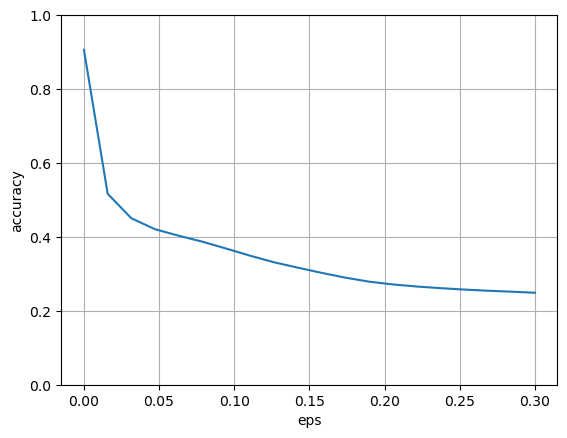

In [6]:
plt.plot(eps_space, unprotected_acc)
plt.xlabel('eps')
plt.ylabel('accuracy')
plt.ylim(ymin=0,ymax=1)
plt.grid()
plt.show()

### Accuracy of the protected model under attack
defender -- can be selected from AdversarialTrainingDefender, QuantizationDefender, DistillationDefender, RegularizationDefender, AutoEncoderDefender and ATQDefender

In [7]:
# Adversarial training on quantized data:
defender = ATQDefender(model)

ATQ training...


Epochs ...:   0%|          | 0/10 [00:00<?, ?it/s]

Steps ...:   0%|          | 0/8615 [00:00<?, ?it/s]

Epoch 1, Loss: 0.4765


Steps ...:   0%|          | 0/8615 [00:00<?, ?it/s]

Epoch 2, Loss: 0.3754


Steps ...:   0%|          | 0/8615 [00:00<?, ?it/s]

Epoch 3, Loss: 0.3646


Steps ...:   0%|          | 0/8615 [00:00<?, ?it/s]

Epoch 4, Loss: 0.3617


Steps ...:   0%|          | 0/8615 [00:00<?, ?it/s]

Epoch 5, Loss: 0.3428


Steps ...:   0%|          | 0/8615 [00:00<?, ?it/s]

Epoch 6, Loss: 0.2908


Steps ...:   0%|          | 0/8615 [00:00<?, ?it/s]

Epoch 7, Loss: 0.2828


Steps ...:   0%|          | 0/8615 [00:00<?, ?it/s]

Epoch 8, Loss: 0.2774


Steps ...:   0%|          | 0/8615 [00:00<?, ?it/s]

Epoch 9, Loss: 0.2787


Steps ...:   0%|          | 0/8615 [00:00<?, ?it/s]

Epoch 10, Loss: 0.2699


In [11]:
protected_acc = []
for eps in eps_space:
    attacker = PGDAttacker(model, eps=eps)
    protected_acc.append(accuracy(attacker, defender, step_size=10))

Creating sequence of samples: 100%|██████████| 560/560 [00:00<00:00, 591.09it/s]


  0%|          | 0/216 [00:00<?, ?it/s]

Creating sequence of samples: 100%|██████████| 560/560 [00:00<00:00, 561.37it/s]


  0%|          | 0/216 [00:00<?, ?it/s]

Creating sequence of samples: 100%|██████████| 560/560 [00:00<00:00, 594.07it/s]


  0%|          | 0/216 [00:00<?, ?it/s]

Creating sequence of samples: 100%|██████████| 560/560 [00:00<00:00, 592.93it/s]


  0%|          | 0/216 [00:00<?, ?it/s]

Creating sequence of samples: 100%|██████████| 560/560 [00:00<00:00, 577.33it/s]


  0%|          | 0/216 [00:00<?, ?it/s]

Creating sequence of samples: 100%|██████████| 560/560 [00:00<00:00, 589.87it/s]


  0%|          | 0/216 [00:00<?, ?it/s]

Creating sequence of samples: 100%|██████████| 560/560 [00:00<00:00, 589.43it/s]


  0%|          | 0/216 [00:00<?, ?it/s]

Creating sequence of samples: 100%|██████████| 560/560 [00:01<00:00, 543.41it/s]


  0%|          | 0/216 [00:00<?, ?it/s]

Creating sequence of samples: 100%|██████████| 560/560 [00:00<00:00, 589.54it/s]


  0%|          | 0/216 [00:00<?, ?it/s]

Creating sequence of samples: 100%|██████████| 560/560 [00:00<00:00, 583.84it/s]


  0%|          | 0/216 [00:00<?, ?it/s]

Creating sequence of samples: 100%|██████████| 560/560 [00:00<00:00, 586.65it/s]


  0%|          | 0/216 [00:00<?, ?it/s]

Creating sequence of samples: 100%|██████████| 560/560 [00:00<00:00, 588.96it/s]


  0%|          | 0/216 [00:00<?, ?it/s]

Creating sequence of samples: 100%|██████████| 560/560 [00:00<00:00, 590.22it/s]


  0%|          | 0/216 [00:00<?, ?it/s]

Creating sequence of samples: 100%|██████████| 560/560 [00:00<00:00, 592.73it/s]


  0%|          | 0/216 [00:00<?, ?it/s]

Creating sequence of samples: 100%|██████████| 560/560 [00:00<00:00, 584.72it/s]


  0%|          | 0/216 [00:00<?, ?it/s]

Creating sequence of samples: 100%|██████████| 560/560 [00:00<00:00, 578.61it/s]


  0%|          | 0/216 [00:00<?, ?it/s]

Creating sequence of samples: 100%|██████████| 560/560 [00:00<00:00, 585.03it/s]


  0%|          | 0/216 [00:00<?, ?it/s]

Creating sequence of samples: 100%|██████████| 560/560 [00:01<00:00, 542.41it/s]


  0%|          | 0/216 [00:00<?, ?it/s]

Creating sequence of samples: 100%|██████████| 560/560 [00:00<00:00, 579.91it/s]


  0%|          | 0/216 [00:00<?, ?it/s]

Creating sequence of samples: 100%|██████████| 560/560 [00:00<00:00, 587.27it/s]


  0%|          | 0/216 [00:00<?, ?it/s]

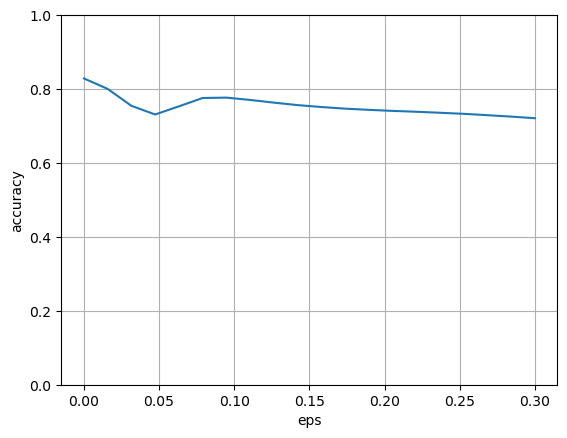

In [12]:
plt.plot(eps_space, protected_acc)
plt.xlabel('eps')
plt.ylabel('accuracy')
plt.ylim(ymin=0,ymax=1)
plt.grid()
plt.show()

In [10]:
attacker = NoAttacker(model, eps=0.05) # no attack
defender = NoDefenceDefender(model) # no defense
acc = accuracy(attacker, defender, step_size=1)
print(f'Accuracy: {acc:.4f}')

Creating sequence of samples: 100%|██████████| 560/560 [00:01<00:00, 517.86it/s]


  0%|          | 0/2154 [00:00<?, ?it/s]

Accuracy: 0.8295
